In [1]:
from IPython.display import Image

# CNTK 206 Part A: Basic GAN with MNIST data

**Prerequisites**: We assume that you have successfully downloaded the MNIST data by completing the tutorial titled CNTK_103A_MNIST_DataLoader.ipynb.

## Introduction

[Generative models](https://en.wikipedia.org/wiki/Generative_model) have gained a [lot of attention](https://openai.com/blog/generative-models/) in deep learning community which has traditionally leveraged [discriminative models](https://en.wikipedia.org/wiki/Discriminative_model) for (semi-supervised) and unsupervised learning. In generative modeling, the idea is to collect a huge amount of data in a domain of interest (e.g., pictures, audio, words) and come up with a trained model that generates such real world data sets. This is an active area of research needing mechanisms to scale up training and having large datasets. As stated in the [OpenAI blog](https://openai.com/blog/generative-models/), such approaches may be used to perform computer aided art generation, or morph images to some word descriptions such as "make my smile wider". This approach has found use in image denoising, inpainting, super-resolution, structured prediction, exploration in reinforcement learning, and neural network pretraining in cases where labeled data is expensive. 

Generating models that can produce realistic content (images, sounds etc.) mimicking real world observations is challenging. Generative Adversarial Network (GAN) is one of the approaches that holds promise. A [quote](https://www.quora.com/What-are-some-recent-and-potentially-upcoming-breakthroughs-in-deep-learning) from Yann LeCun summarizes GAN and its variations as the most important idea in the last 10 years. The original idea was proposed by [Goodfellow et al](https://arxiv.org/pdf/1406.2661v1.pdf) at NIPS  2014. In this tutorial, we show how to use the Cognitive Toolkit to create a basic GAN network for generating synthetic MNIST digits.

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

import cntk as C
from cntk import Trainer
from cntk.device import try_set_default_device, gpu, cpu
from cntk.initializer import xavier
from cntk.io import (MinibatchSource, CTFDeserializer, StreamDef, StreamDefs,
                     INFINITELY_REPEAT, FULL_DATA_SWEEP)
from cntk.layers import Dense, default_options, Input
from cntk.learners import (fsadagrad, UnitType, sgd, learning_rate_schedule,
                          momentum_as_time_constant_schedule)
from cntk.logging import ProgressPrinter

%matplotlib inline

### Select the notebook runtime environment devices / settings

Set the device to cpu / gpu for the test environment. If you have both CPU and GPU on your machine, you can optionally switch the devices. By default, we choose the best available device.

In [3]:
# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    import cntk
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))               

There are two run modes:
- *Fast mode*: `isFast` is set to `True`. This is the default mode for the notebooks, which means we train for fewer iterations or train / test on limited data. This ensures functional correctness of the notebook though the models produced are far from what a completed training would produce.

- *Slow mode*: We recommend the user to set this flag to `False` once the user has gained familiarity with the notebook content and wants to gain insight from running the notebooks for a longer period with different parameters for training. 

**Note**
If the `isFlag` is set to `False` the notebook will take a few hours on a GPU enabled machine. You can try fewer iterations by setting the `num_minibatches` to a smaller number say `20,000` which comes at the expense of quality of the generated images.

In [4]:
isFast = True 

## Data Reading
The input to the GAN will be a vector of random numbers. At the end of the traning, the GAN "learns" to generate images of hand written digits drawn from the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database). We will be using the same MNIST data generated in tutorial 103A.  A more in-depth discussion of the data format and reading methods can be seen in previous tutorials.  For our purposes, just know that the following function returns an object that will be used to generate images from the MNIST dataset.  Since we are building an unsupervised model, we only need to read in `features` and ignore the `labels`.

In [5]:
# Ensure the training data is generated and available for this tutorial
# We search in two locations in the toolkit for the cached MNIST data set.

data_found = False
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    if os.path.isfile(train_file):
        data_found = True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
    
print("Data directory is {0}".format(data_dir))

Data directory is ..\Examples\Image\DataSets\MNIST


In [6]:
def create_reader(path, is_training, input_dim, label_dim):
    deserializer = CTFDeserializer(
        filename = path,
        streams = StreamDefs(
            labels_unused = StreamDef(field = 'labels', shape = label_dim, is_sparse = False),
            features = StreamDef(field = 'features', shape = input_dim, is_sparse = False
            )
        )
    )
    return MinibatchSource(
        deserializers = deserializer,
        randomize = is_training,
        epoch_size = INFINITELY_REPEAT if is_training else FULL_DATA_SWEEP
    )

The random noise we will use to train the GAN is provided by the `noise_sample` function to generate random noise samples from a uniform distribution within the interval [-1, 1].

In [7]:
np.random.seed(123)
def noise_sample(num_samples):
    return np.random.uniform(
        low = -1.0,
        high = 1.0,
        size = [num_samples, g_input_dim]
    )

## Model Creation

A GAN network is composed of two sub-networks, one called the Generator ($G$) and the other Discriminator ($D$). 
- The **Generator** takes random noise vector ($z$) as input and strives to output synthetic (fake) image ($x^*$) that is indistinguishable from the real image ($x$) from the MNIST dataset. 
- The **Discriminator** strives to differentiate between the real image ($x$) and the fake ($x^*$) image.

In [8]:
# Figure 1
Image(url="https://www.cntk.ai/jup/GAN_basic_flow.png")

In each training iteration, the Generator produces more realistic fake images (in other words *minimizes* the difference between the real and generated counterpart) and also the Discriminator *maximizes* the probability of assigning the correct label (real vs. fake) to both real examples (from training set) and the generated fake ones. The two conflicting objectives between the sub-networks ($G$ and $D$) leads to the GAN network (when trained) converge to an equilibrium, where the Generator produces realistic looking fake MNIST images and the Discriminator can at best randomly guess whether images are real or fake. The resulting Generator model once trained produces realistic MNIST image with the input being a random number. 

### Model config

First, we establish some of the architectural and training hyper-parameters for our model.  

- The generator network is a fully-connected network with a single hidden layer.  The input will be a 10-dimensional random vector and the output will be a 784 dimensional vector, corresponding to a flattened version of a 28 x 28 fake  image.  The discriminator is also a single layer dense network.  It takes as input the 784 dimensional output of the generator or a real MNIST image and outputs a single scalar - the estimated probability that the input image is a real MNIST image.

### Model components
We build a computational graph for our model, one each for the generator and the discriminator. First, we establish some of the architectural parameters of our model. 

- The generator takes a 100-dimensional random vector (for starters) as input ($z$) and the outputs a 784 dimensional vector, corresponding to a flattened version of a 28 x 28 fake (synthetic) image ($x^*$). In this tutorial we simply model the generator with two dense layers. We use a tanh activation on the last layer to make sure that the output of the generator function is confined to the interval [-1, 1]. This is necessary because we also scale the MNIST images to this interval, and the outputs of the generator must be able to emulate the actual images as closely as possible.


- The discriminator takes as input ($x^*$) the 784 dimensional output of the generator or a real MNIST image and outputs the estimated probability that the input image is a real MNIST image. We also model this with two dense layers with a sigmoid activation in the last layer ensuring that the discriminator produces a valid probability.

In [9]:
# architectural parameters
g_input_dim = 100
g_hidden_dim = 128
g_output_dim = d_input_dim = 784
d_hidden_dim = 128
d_output_dim = 1

In [10]:
def generator(z):
    with default_options(init = xavier()):
        h1 = Dense(g_hidden_dim, activation = C.relu)(z)
        return Dense(g_output_dim, activation = C.tanh)(h1)

In [11]:
def discriminator(x):
    with default_options(init = xavier()):
        h1 = Dense(d_hidden_dim, activation = C.relu)(x)
        return Dense(d_output_dim, activation = C.sigmoid)(h1)

We use a minibatch size of 1024 and a fixed learning rate of 0.0005 for training. In the fast mode (`isFast = True`)  we verify only functional correctness with 200 iterations. 

**Note**: In the slow mode, the results look a lot better but it requires patient waiting (few hours) depending on your hardware. In general, the more number of minibatches one trains, the better is the fidelity of the generated images.

In [12]:
# training config
minibatch_size = 1024
num_minibatches = 300 if isFast else 40000
lr = 0.00005

### Build the graph

The rest of the computational graph is mostly responsible for coordinating the training algorithms and parameter updates, which is particularly tricky with GANs for couple reasons. 

- First, the discriminator must be used on both the real MNIST images and fake images generated by the generator function.  One way to represent this in the computational graph is to create a clone of the output of the discriminator function, but with substituted inputs.  Setting `method=share` in the `clone` function ensures that  both paths through the discriminator model use the same set of parameters.


- Second, we need to update the parameters for the generator and discriminator model separately using the gradients from different loss functions.  We can get the parameters for a `Function` in the graph with the `parameters` attribute.  However, when updating the model parameters, update only the parameters of the respective models while keeping the other parameters unchanged. In other words, when updating the generator we will update only the parameters of the $G$ function while keeping the parameters of the $D$ function fixed and vice versa.

### Training the Model
The code for training the GAN very closely follows the algorithm as presented in the [original NIPS 2014 paper](https://arxiv.org/pdf/1406.2661v1.pdf). In this implementation, we train $D$ to maximize the probability of assigning the correct label (fake vs. real) to both training examples and the samples from $G$. In other words, $D$ and $G$ play the following two-player minimax game with the value function $V(G,D)$:

$$
    \min_G \max_D V(D,G)= \mathbb{E}_{x}[ log D(x) ] + \mathbb{E}_{z}[ log(1 - D(G(z))) ]
$$

At the optimal point of this game the generator will produce realistic looking data while the discriminator will predict that the generated image is indeed fake with a probability of 0.5. The [algorithm referred below](https://arxiv.org/pdf/1406.2661v1.pdf) is implemented in this tutorial.

In [13]:
# Figure 2
Image(url="https://www.cntk.ai/jup/GAN_goodfellow_NIPS2014.png", width = 500)

In [14]:
def build_graph(noise_shape, image_shape,
                G_progress_printer, D_progress_printer):
    input_dynamic_axes = [C.Axis.default_batch_axis()]
    Z = Input(noise_shape, dynamic_axes=input_dynamic_axes)
    X_real = Input(image_shape, dynamic_axes=input_dynamic_axes)
    X_real_scaled = 2*(X_real / 255.0) - 1.0

    # Create the model function for the generator and discriminator models
    X_fake = generator(Z)
    D_real = discriminator(X_real_scaled)
    D_fake = D_real.clone(
        method = 'share',
        substitutions = {X_real_scaled.output: X_fake.output}
    )

    # Create loss functions and configure optimazation algorithms
    G_loss = 1.0 - C.log(D_fake)
    D_loss = -(C.log(D_real) + C.log(1.0 - D_fake))

    G_learner = fsadagrad(
        parameters = X_fake.parameters,
        lr = learning_rate_schedule(lr, UnitType.sample),
        momentum = momentum_as_time_constant_schedule(700)
    )
    D_learner = fsadagrad(
        parameters = D_real.parameters,
        lr = learning_rate_schedule(lr, UnitType.sample),
        momentum = momentum_as_time_constant_schedule(700)
    )

    # Instantiate the trainers
    G_trainer = Trainer(
        X_fake,
        (G_loss, None),
        G_learner,
        G_progress_printer
    )
    D_trainer = Trainer(
        D_real,
        (D_loss, None),
        D_learner,
        D_progress_printer
    )

    return X_real, X_fake, Z, G_trainer, D_trainer

With the value functions defined we proceed to interatively train the GAN model. The training of the model can take significnantly long depending on the hardware especiallly if `isFast` flag is turned off.

In [15]:
def train(reader_train):
    k = 2
    
    # print out loss for each model for upto 50 times
    print_frequency_mbsize = num_minibatches // 50
    pp_G = ProgressPrinter(print_frequency_mbsize)
    pp_D = ProgressPrinter(print_frequency_mbsize * k)

    X_real, X_fake, Z, G_trainer, D_trainer = \
        build_graph(g_input_dim, d_input_dim, pp_G, pp_D)
    
    input_map = {X_real: reader_train.streams.features}
    for train_step in range(num_minibatches):

        # train the discriminator model for k steps
        for gen_train_step in range(k):
            Z_data = noise_sample(minibatch_size)
            X_data = reader_train.next_minibatch(minibatch_size, input_map)
            if X_data[X_real].num_samples == Z_data.shape[0]:
                batch_inputs = {X_real: X_data[X_real].value, Z: Z_data}
                D_trainer.train_minibatch(batch_inputs)

        # train the generator model for a single step
        Z_data = noise_sample(minibatch_size)
        batch_inputs = {Z: Z_data}
        G_trainer.train_minibatch(batch_inputs)

        G_trainer_loss = C.utils.get_train_loss(G_trainer)

    return Z, X_fake, G_trainer_loss

In [16]:
reader_train = create_reader(train_file, True, d_input_dim, label_dim=10)

G_input, G_output, G_trainer_loss = train(reader_train)

S:\src\cntk\1\cntk\bindings\python\cntk\core.py:227: UserWarning: your data is of type "float64", but your input variable (uid "Input3") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


 Minibatch[   1-  12]: loss = 0.435653 * 12288, metric = 0.00% * 12288;
 Minibatch[   1-   6]: loss = 2.737928 * 6144, metric = 0.00% * 6144;
 Minibatch[  13-  24]: loss = 0.518323 * 12288, metric = 0.00% * 12288;
 Minibatch[   7-  12]: loss = 2.355193 * 6144, metric = 0.00% * 6144;
 Minibatch[  25-  36]: loss = 0.465481 * 12288, metric = 0.00% * 12288;
 Minibatch[  13-  18]: loss = 2.486607 * 6144, metric = 0.00% * 6144;
 Minibatch[  37-  48]: loss = 0.504487 * 12288, metric = 0.00% * 12288;
 Minibatch[  19-  24]: loss = 2.644568 * 6144, metric = 0.00% * 6144;
 Minibatch[  49-  60]: loss = 0.892741 * 12288, metric = 0.00% * 12288;
 Minibatch[  25-  30]: loss = 2.252815 * 6144, metric = 0.00% * 6144;
 Minibatch[  61-  72]: loss = 1.090686 * 12288, metric = 0.00% * 12288;
 Minibatch[  31-  36]: loss = 1.909616 * 6144, metric = 0.00% * 6144;
 Minibatch[  73-  84]: loss = 1.212030 * 12288, metric = 0.00% * 12288;
 Minibatch[  37-  42]: loss = 1.826308 * 6144, metric = 0.00% * 6144;
 Minib

In [17]:
# Print the generator loss 
print("Training loss of the generator is: {0:.2f}".format(G_trainer_loss))

Training loss of the generator is: 1.79


## Generating Fake (Synthetic) Images

Now that we have trained the model, we can create fake images simply by feeding random noise into the generator and displaying the outputs.  Below are a few images generated from random samples.  To get a new set of samples, you can re-run the last cell.

S:\src\cntk\1\cntk\bindings\python\cntk\core.py:227: UserWarning: your data is of type "float64", but your input variable (uid "Input3") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


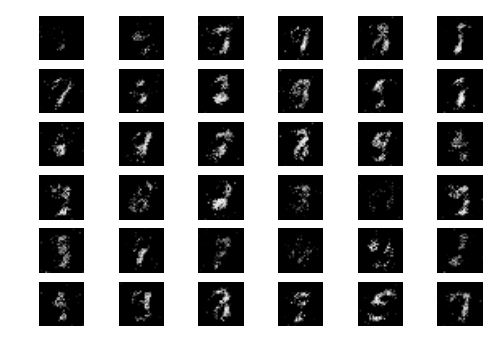

In [18]:
def plot_images(images, subplot_shape):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(*subplot_shape)
    for image, ax in zip(images, axes.flatten()):
        ax.imshow(image.reshape(28, 28), vmin = 0, vmax = 1.0, cmap = 'gray')
        ax.axis('off')
    plt.show()
    
noise = noise_sample(36)
images = G_output.eval({G_input: noise})
plot_images(images, subplot_shape =[6, 6])

Larger number of iterations should generate more realistic looking MNIST images. A sampling of such generated images are shown below.

In [19]:
# Figure 3
Image(url="http://www.cntk.ai/jup/GAN_basic_slowmode.jpg")

**Note**: It takes a large number of iterations to capture a representation of the real world signal. Even simple dense networks can be quite effective in modelling data albeit MNIST is a relatively simple dataset as well.

**Suggested Task**

- Explore the impact of changing the dimension of the input random noise (say from 100 to 10) in terms of computation time, loss and memory footprint for the same number of iterations.

- Scale the image from 0 to 1. What other changes in the network are needed?

- Performance is a key aspect to deep neural networks training. Study how the changing the minibatch sizes impact the performance both with regards to quality of the generated images and the time it takes to train a model.

- Try generating fake images using the CIFAR-10 data set as the training data. How does the network above perform?
